<strong><b><font size="5">Data Science Academy</font></b></strong>

<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="5">Aula 21</font></b></strong>

<strong><b><font size="4">Prevendo a Média Mensal de Vendas - Otimizando o Modelo Prophet Considerando Feriados</font></b></strong>

Todas as aulas deste curso podem ser encontradas na timeline da Comunidade em nosso portal: www.datascienceacademy.com.br

**Prophet**

Na aula anterior criamos um Modelo Prophet básico que superou a performance do nosso melhor modelo SARIMAX. Considerando que o Prophet foi criado em 2017 e o SARIMAX está no mercado pelo menos a 50 anos, é algo que chama atenção.

De fato o Prophet supera em performance muitos dos modelos mais robustos usados em séries temporais (nas próximas aulas descobriremos se ele supera ou não modelos de Deep Learning).

E vamos estudar nesta aula um dos recursos mais notáveis do Prophet e que permite aumentar a performance ainda mais. Vamos incluir uma variável externa (chamada variável exógena) para modelar os feriados. Fizemos isso com o modelo SARIMAX, mas deu certo trabalho. Com o Prophet é super simples e um recurso poderoso pois o feriado é considerado um dos componentes do modelo. O algoritmo Prophet espera receber feriados para modelar as séries temporais.

Você sabe que nossa série de exemplo aqui no curso é uma série mensal de média de vendas de produtos de tecnologia. Não faz sentido falar em modelagem de feriados em casos assim e o que vamos fazer é ensinar a você como adicionar feriados ao modelo. A performance final do modelo será ainda melhor, mas nada para celebrar (pois o feriado não faz sentido em uma série mensal de vendas como em nosso exemplo), mas é algo para aprender e usar como referência.

Vamos ao trabalho.

### Carregando os Pacotes Usados Neste Jupyter Notebook

In [0]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook, se necessário.

In [0]:
# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [0]:
# Instala o plotly
!pip install -q plotly

In [0]:
# O comando abaixo instala o plotly-orca para gráficos interativos
# Se necessário, reinicie o Jupyter Notebook
# https://github.com/plotly/orca
# Não funciona no Google Colab, a menos que você instale o mini-conda no Google Colab. Pesquise sobre como fazer isso.
#!conda install -y -c plotly plotly-orca

In [0]:
# O statsmodels deve ser atualizado
!pip install -q -U statsmodels

     |████████████████████████████████| 8.7MB 2.7MB/s 


In [0]:
# Instala o pacote Prophet
!pip install -q fbprophet

In [0]:
# Pacote para ajuste de data
!pip install -q convertdate

In [0]:
# As novas versões do Pandas e Matplotlib trazem diversas mensagens de aviso ao desenvolvedor. Vamos desativar isso.
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import numpy as np
import pandas as pd
import itertools
from pandas import Series

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns
import plotly as py
import plotly.express as px
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Imports para modelagem preditiva
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
import scipy
import scipy.stats as scs
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import jarque_bera
import fbprophet
from fbprophet import Prophet

# Imports para métricas e performance do modelo
import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# Imports para formatação dos gráficos
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 15,7
matplotlib.style.use('ggplot')
%matplotlib inline

In [0]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

numpy           1.18.2
plotly          4.4.1
seaborn         0.10.0
scipy           1.4.1
fbprophet       0.6
statsmodels.api 0.11.1
statsmodels     0.11.1
sklearn         0.22.2.post1
matplotlib      3.2.1
pandas          1.0.3
Data Science Academy


## Definição do Problema de Negócio

A HappyMoonVC é uma Venture Capital (VC).

Além do investimento no GoInRail (descrito nas aulas anteriores), a HappyMoonVC está analisando um outro negócio. Uma rede de varejo que poderá fornecer produtos para os clientes do GoInRail (drone elétrico para transporte de passageiros). 

Um monitor touch-screen dentro do GoInRail permitiria que o cliente fizesse a compra de produtos enquanto faz a viagem, com a opção de pegar o produto na estação que for descer ou então receber direto na residência (se acha que isso é futurista demais, saiba que já existe no metrô do Japão).

Para decidir se o investimento vale a pena, a HappyMoonVC precisa prever o volume de vendas.  

Esse é nosso trabalho.

## Conjunto de Dados

Usaremos conjuntos de dados que está disponível publicamente no site do Tableau e que representa as vendas históricas da empresa na qual a HappyMoonVC pretende investir. Aqui o link do dataset (que está sendo fornecido para você):

https://community.tableau.com/docs/DOC-1236

De todos os dados disponíveis, nosso interesse é na categoria de produtos de tecnologia.

In [0]:
# Carrega os dados
dados = pd.read_csv('https://raw.githubusercontent.com/dsacademybr/Datasets/master/dataset6.csv')

In [0]:
# Shape
dados.shape

(9994, 21)

In [0]:
# Colunas
dados.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

### Análise Exploratória

In [0]:
# Visualizando os dados
dados.head(3)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714


In [0]:
# Resumo estatístico
dados.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


In [0]:
# Checando valores missing - não temos valores missing no dataset
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

In [0]:
# Ajustando o nome das colunas para que todas fiquem com letras minúsculas
dados.columns = map(str.lower, dados.columns)

In [0]:
# Vamos substituir os espaços e traços nos nomes das colunas por '_'
dados.columns = dados.columns.str.replace(" ", "_")
dados.columns = dados.columns.str.replace("-", "_")

In [0]:
# Conferindo
dados.columns

Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'country', 'city', 'state',
       'postal_code', 'region', 'product_id', 'category', 'sub_category',
       'product_name', 'sales', 'quantity', 'discount', 'profit'],
      dtype='object')

Vamos separar os dados por categoria (Móveis, Tecnologia, Material de escritório).

In [0]:
# Separando os dados por categoria
df_tecnologia = dados.loc[dados['category'] == 'Technology']
df_moveis = dados.loc[dados['category'] == 'Furniture']
df_office = dados.loc[dados['category'] == 'Office Supplies']

Agora vamos preparar as séries temporais.

In [0]:
# Agregando as vendas pela data do pedido
ts_tecnologia = df_tecnologia.groupby('order_date')['sales'].sum().reset_index()
ts_moveis = df_moveis.groupby('order_date')['sales'].sum().reset_index()
ts_office = df_office.groupby('order_date')['sales'].sum().reset_index()

Acesse o <a href="http://datascienceacademy.com.br/blog/">Blog da DSA</a> e fique por dentro das novidades em Data Science, Big Data, IA, RPA, Blockchain e mercado de trabalho.

In [0]:
# Como está ficando o nosso dataset de interesse?
ts_tecnologia

,order_date,sales
0,2014-01-06,1147.940
1,2014-01-09,31.200
2,2014-01-13,646.740
3,2014-01-15,149.950
4,2014-01-16,124.200
...,...,...
819,2017-12-25,401.208
820,2017-12-27,164.388
821,2017-12-28,14.850
822,2017-12-29,302.376


Vamos mover a data para o índice e assim criar a série temporal.

In [0]:
# Colocando a data como índice
ts_tecnologia = ts_tecnologia.set_index('order_date')

In [0]:
# Visualizando a série
ts_tecnologia

,sales
order_date,
2014-01-06,1147.940
2014-01-09,31.200
2014-01-13,646.740
2014-01-15,149.950
2014-01-16,124.200
...,...
2017-12-25,401.208
2017-12-27,164.388
2017-12-28,14.850


Agora podemos conferir a performance de vendas ao longo do tempo.

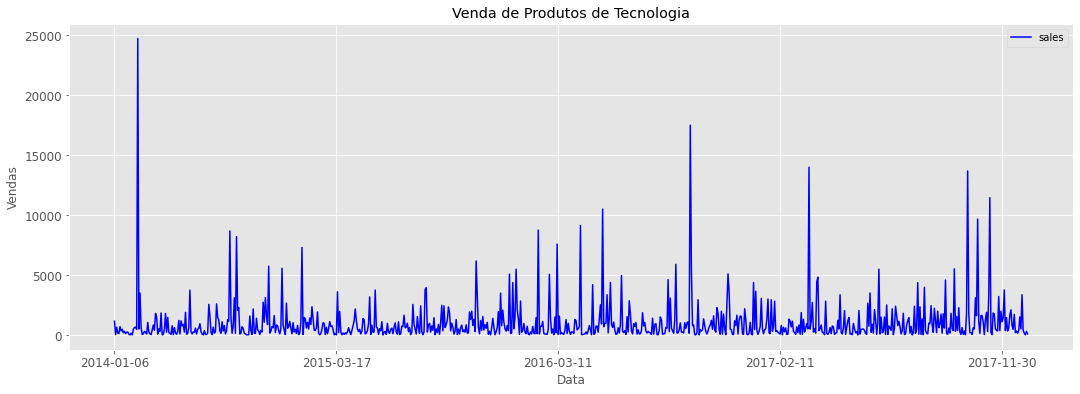

In [0]:
# Venda de Produtos de Tecnologia
vendas_tecnologia = ts_tecnologia[['sales']]
ax = vendas_tecnologia.plot(color = 'b', figsize = (18,6))
plt.xlabel("Data")
plt.ylabel('Vendas')
plt.title("Venda de Produtos de Tecnologia")
plt.show()

Vamos ajustar o indice do tipo Index para o tipo DateTimeIndex (o que caracteriza uma série temporal), pois faremos uma agregação pela média para analisar a venda média ao longo do tempo. 

In [0]:
# Conferindo o tipo do índice
type(vendas_tecnologia.index)

pandas.core.indexes.base.Index

In [0]:
# Alterando o tipo do índice
vendas_tecnologia.index = pd.to_datetime(vendas_tecnologia.index)

In [0]:
# Conferindo o tipo do índice
type(vendas_tecnologia.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [0]:
# Reamostrando os dados para frequência mensal
# Usando o valor médio das vendas diárias - definimos o mês como índice
media_vendas_tecnologia = vendas_tecnologia['sales'].resample('MS').mean()

In [0]:
# Verificando o tipo resultante
type(media_vendas_tecnologia)

pandas.core.series.Series

In [0]:
# Checando os dados
media_vendas_tecnologia

order_date
2014-01-01     449.041429
2014-02-01     229.787143
2014-03-01    2031.948375
2014-04-01     613.028933
2014-05-01     564.698588
2014-06-01     766.905909
2014-07-01     533.608933
2014-08-01     708.435385
2014-09-01    2035.838133
2014-10-01     596.900900
2014-11-01    1208.056320
2014-12-01    1160.732889
2015-01-01     925.070800
2015-02-01     431.121250
2015-03-01     574.662333
2015-04-01     697.559500
2015-05-01     831.642857
2015-06-01     429.024400
2015-07-01     691.397733
2015-08-01    1108.902286
2015-09-01     950.856400
2015-10-01     594.716111
2015-11-01    1037.982652
2015-12-01    1619.637636
2016-01-01     374.671067
2016-02-01    1225.891400
2016-03-01    1135.150105
2016-04-01     875.911882
2016-05-01    1601.816167
2016-06-01    1023.259500
2016-07-01     829.312500
2016-08-01     483.620100
2016-09-01    1144.170300
2016-10-01    1970.835875
2016-11-01    1085.642360
2016-12-01     970.554870
2017-01-01    1195.218071
2017-02-01     430.501714
2

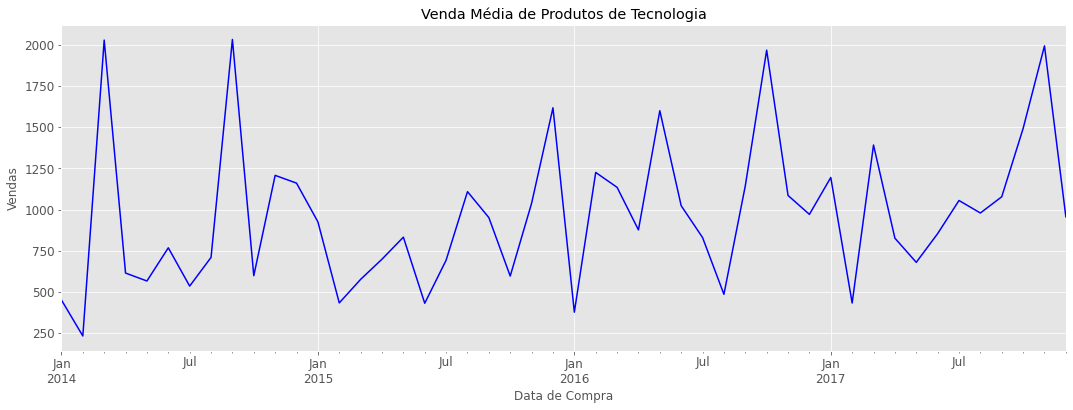

In [0]:
# Venda Média de Produtos de Tecnologia
media_vendas_tecnologia.plot(figsize = (18, 6), color = 'blue')
plt.xlabel("Data de Compra")
plt.ylabel('Vendas')
plt.title("Venda Média de Produtos de Tecnologia")
plt.show()

Agora, vamos decompor uma das séries para avaliar seus componentes.

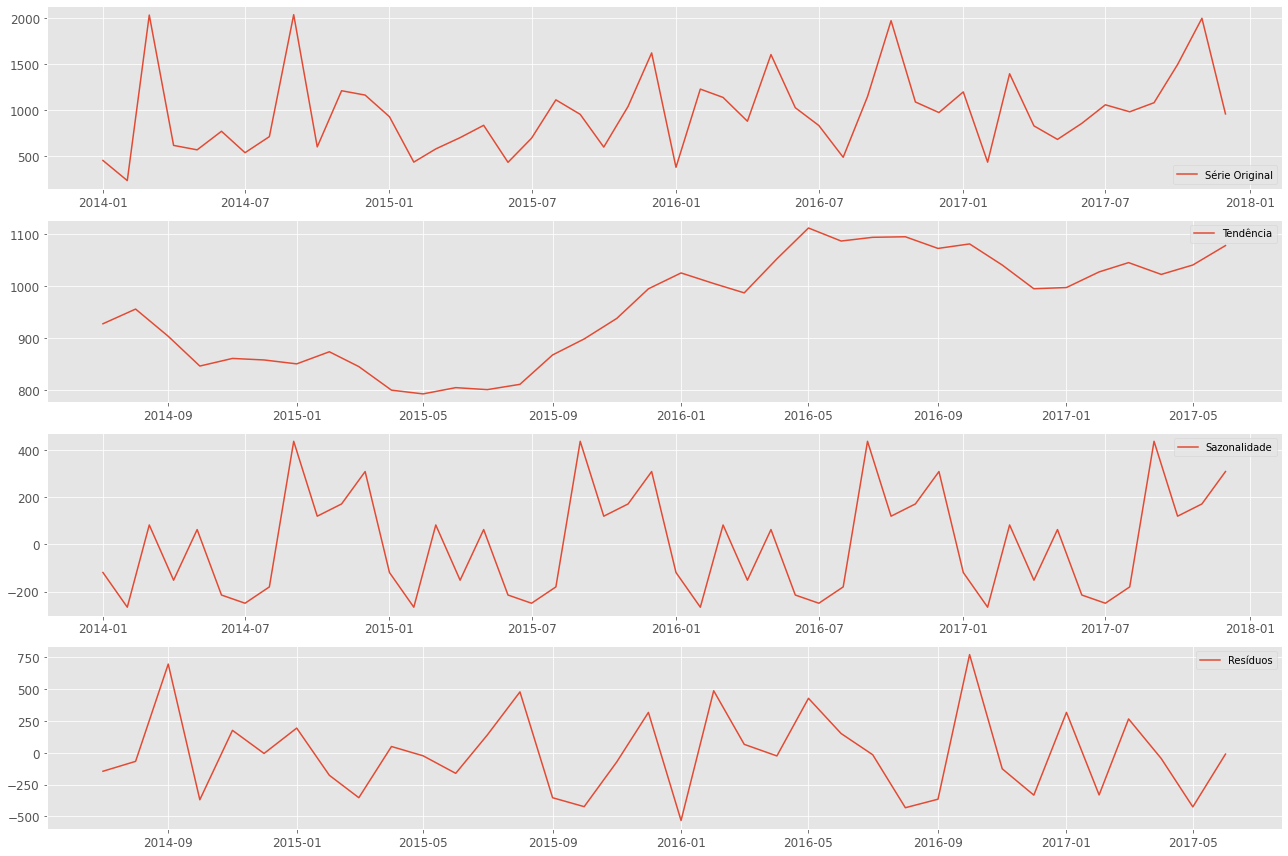

In [0]:
# Decomposição da série temporal de venda média de produtos de tecnologia
decomposition = seasonal_decompose(media_vendas_tecnologia, period = 12)
rcParams['figure.figsize'] = 18, 12

# Componentes
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot
plt.subplot(411)
plt.plot(media_vendas_tecnologia, label = 'Série Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Tendência')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Sazonalidade')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Resíduos')
plt.legend(loc = 'best')
plt.tight_layout()

Vamos testar a estacionaridade.

In [0]:
# Função para testar a estacionaridade
def testa_estacionaridade(serie):
    
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = 12).mean()
    rolstd = serie.rolling(window = 12).std()

    # Plot das estatísticas móveis
    orig = plt.plot(serie, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show()
    
    # Teste Dickey-Fuller:
    # Print
    print('\nResultado do Teste Dickey-Fuller:\n')

    # Teste
    dfteste = adfuller(serie, autolag = 'AIC')

    # Formatando a saída
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])

    # Loop por cada item da saída do teste
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)'%key] = value

    # Print
    print (dfsaida)
    
    # Testa o valor-p
    print ('\nConclusão:')
    if dfsaida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')

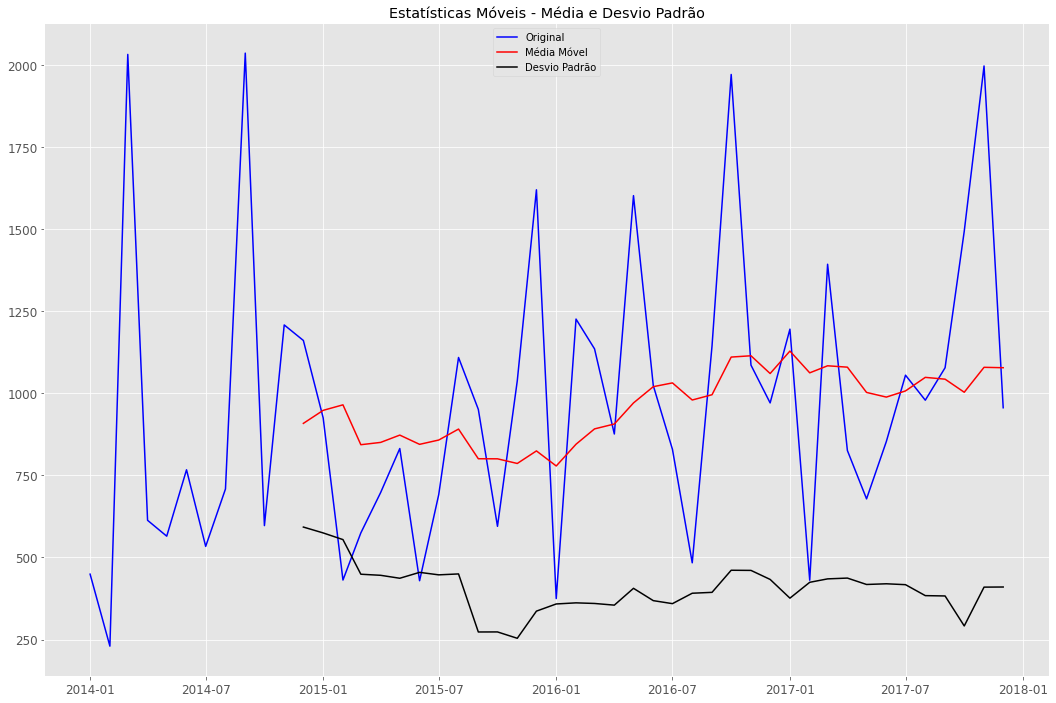


Resultado do Teste Dickey-Fuller:

Estatística do Teste           -7.187969e+00
Valor-p                         2.547334e-10
Número de Lags Consideradas     0.000000e+00
Número de Observações Usadas    4.700000e+01
Valor Crítico (1%)             -3.577848e+00
Valor Crítico (5%)             -2.925338e+00
Valor Crítico (10%)            -2.600774e+00
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [0]:
# Verifica se a série é estacionária
testa_estacionaridade(media_vendas_tecnologia)

### Dividindo os Dados em Treino e Teste

In [0]:
# Divisão em treino e teste
X = media_vendas_tecnologia
train_size = int(len(X) * 0.75)
trainset, testset = X[0:train_size], X[train_size:]

In [0]:
len(trainset)

36

In [0]:
len(testset)

12

### Função Para o Cálculo da Acurácia

In [0]:
# Função
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print('MSE das previsões é {}'.format(round(mse, 2))+
                  '\nRMSE das previsões é {}'.format(round(np.sqrt(mse), 2))+
                  '\nMAPE das previsões é {}'.format(round(mape, 2))))

Acesse o <a href="http://datascienceacademy.com.br/blog/">Blog da DSA</a> e fique por dentro das novidades em Data Science, Big Data, IA, RPA, Blockchain e mercado de trabalho.

## Modelo Prophet

Se você tiver feriados ou outros eventos recorrentes que deseja modelar em seu modelo de série temporal, deverá criar um dataframe para eles quando usar o Prophet. 

O Prophet requer um dataframe com duas colunas (holiday e ds) e uma linha para cada ocorrência do feriado. O dataframe deve incluir todas as ocorrências do feriado, tanto no passado (os dados históricos) quanto no futuro (até onde a previsão está sendo feita). Se eles não se repetirem no futuro, o Prophet os modelará e não os incluirá na previsão (e esse recurso á fabuloso, pois ao invés de gerar erros como em outras ferramentas, o Prophet modela o feriado futuro, mas não o utiliza se o feriado não existir. Simples, não?).

Você também pode incluir as colunas lower_window e upper_window, que estendem o feriado para [lower_window, upper_window] dias em torno da data. Por exemplo, se você deseja incluir a véspera de Natal, além do Natal, pode definir os parâmetros assim: lower_window = -1, upper_window = 0. Com isso você cria um "feriadão" por exemplo. 

Nossa série temporal é a média mensal e assim a variável externa de feriado não faz muito sentido e o exemplo abaixo é apenas didático para que você aprenda como aplicar o conceito no Prophet, pois isso aumenta de forma considerável as previsões do modelo. Optamos por fazer isso, pois essa série temporal continuará sendo usada nas aulas seguintes com os demais modelos que estudaremos ainda no curso.

Outras variáveis podem ser adicionadas ao modelo Prophet, se você desejar. Documentação dos feriados:

https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html

Vamos preparar os dados para o Prophet.

Aqui está o dataframe para os feriados. Vamos incluir o feriado de Reveillon pois esse é bem fácil, já que é o dia 01 de Janeiro de cada ano. Vamos incluir somente 3 datas, pois vou ensinar outro truque para você logo abaixo.

Observer que criamos um dicionário e depois usamos para criar o dataframe.

In [0]:
# Dataframe para o feriado de Reveillon
feriado_ano_novo = pd.DataFrame({'holiday': "New Year's Day", 
                                 'ds' : pd.to_datetime(['2014-01-01', 
                                                        '2015-01-01', 
                                                        '2016-01-01'])}) 

Nas duas próximas células não temos mudanças. O mesmo procedimento usado na aula anterior.

In [0]:
# Criando dataframes para dados de treino e teste
df_treino = pd.DataFrame({'order_date':trainset.index, 'sales':trainset.values})
df_teste = pd.DataFrame({'order_date':testset.index, 'sales':testset.values})

In [0]:
# Renomeando as colunas, pois o Prophet requer o nome específico, 'ds' e 'y'. 
df_treino = df_treino.rename(columns = {'order_date': 'ds', 'sales': 'y'})
df_teste = df_teste.rename(columns = {'order_date': 'ds', 'sales': 'y'})

Ao criar o modelo, adicionamos o parâmetro holiday e indicamos o dataframe com os feriados, conforme está na célula abaixo. 

Pronto, só isso. O restante do trabalho quem faz é o Prophet.

In [0]:
# Cria o modelo Prophet com sazonalidade anual e dataframe com os feriados
modelo_prophet = Prophet(yearly_seasonality = True, holidays = feriado_ano_novo)

Mas aqui eu tenho um truque na manga. 

Nós não incluímos os feriados futuros no dataframe de feriados. Com isso, o Prophet iria usar o dataframe de feriados para a modelagem, mas não na previsão. Porém, podemos usar o recurso de Builti-in Country Holiday do Prophet. 

O Prophet já traz um dicionário de feriados devidamente mapeados por país. Tudo que precisamos é adicionar isso ao modelo como está na célula abaixo. E tem dicionário para o Brasil.

Confira aqui: https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#built-in-country-holidays

Com isso, o Prophet completa as datas de feriados nos anos futuros. Demais, não é? Depois, execute todo o Jupyter Notebook, comentado a linha na célula abaixo para conferir a diferença e como a performance cai sem esta opção.

In [0]:
# Adicionando o Builti-in Country Holiday ao modelo
modelo_prophet.add_country_holidays(country_name = 'US')

Daqui em diante não tem mais diferenças. Ahh, claro. Tem diferença nas métricas lá no final.

In [0]:
# Treinamento
modelo_prophet.fit(df_treino) 

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Modelo treinado. Agora devemos criar o dataset para as previsões com o modelo. Temos uma função para isso no Prophet, chamada make_future_dataframe. Passamos 12 períodos e freqência mensal (MS). Como temos 4 anos de dados, serão criados 4 conjuntos de 12, logo 48 no total.

In [0]:
# Dataset para as previsões
dataset_para_previsoes = modelo_prophet.make_future_dataframe(periods = 12, freq = 'MS')
dataset_para_previsoes.count()

ds    48
dtype: int64

Podemos agora fazer o Forecast.

In [0]:
# Forecast
forecast_modelo_prophet = modelo_prophet.predict(dataset_para_previsoes)

In [0]:
# Aqui estão algumas das previsões feitas pelo modelo
forecast_modelo_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
43,2017-08-01,790.707497,459.711694,1075.668153
44,2017-09-01,1218.777403,929.400716,1520.267460
45,2017-10-01,1566.094812,1266.445092,1881.938053
46,2017-11-01,1315.903621,1002.821252,1627.758270
47,2017-12-01,1343.235540,1031.308615,1639.651344


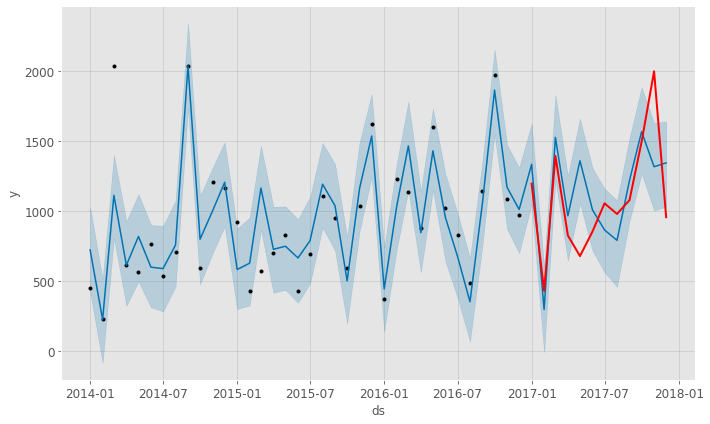

In [0]:
# Vamos criar um Plot e conferir as previsões

# Plot das previsões
fig = modelo_prophet.plot(forecast_modelo_prophet)

# Dados de Teste em vermelho
plt.plot(testset, label = 'Teste', color = 'red', linewidth = 2)
plt.show()

In [0]:
# As previsões do Prophet retornam diversos valores:
forecast_modelo_prophet.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),Christmas Day (Observed)_lower,Christmas Day (Observed)_upper,Columbus Day,Columbus Day_lower,Columbus Day_upper,Independence Day,Independence Day_lower,Independence Day_upper,Independence Day (Observed),Independence Day (Observed)_lower,Independence Day (Observed)_upper,Labor Day,Labor Day_lower,Labor Day_upper,"Martin Luther King, Jr. Day","Martin Luther King, Jr. Day_lower","Martin Luther King, Jr. Day_upper",Memorial Day,Memorial Day_lower,Memorial Day_upper,New Year's Day,New Year's Day_lower,New Year's Day_upper,Thanksgiving,Thanksgiving_lower,Thanksgiving_upper,Veterans Day,Veterans Day_lower,Veterans Day_upper,Washington's Birthday,Washington's Birthday_lower,Washington's Birthday_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-01-01,925.615137,423.058432,1027.002286,925.615137,925.615137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-860.551851,-860.551851,-860.551851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-203.302048,-203.302048,-203.302048,-860.551851,-860.551851,-860.551851,657.249803,657.249803,657.249803,0.0,0.0,0.0,722.313089
1,2014-02-01,935.580145,-83.064470,512.495213,935.580145,935.580145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-709.376810,-709.376810,-709.376810,0.000000,0.000000,0.000000,-709.376810,-709.376810,-709.376810,0.0,0.0,0.0,226.203335
2,2014-03-01,944.580797,807.004101,1399.489307,944.580797,944.580797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,167.586272,167.586272,167.586272,0.000000,0.000000,0.000000,167.586272,167.586272,167.586272,0.0,0.0,0.0,1112.167069
3,2014-04-01,954.545805,323.175569,925.428879,954.545805,954.545805,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-341.771260,-341.771260,-341.771260,0.000000,0.000000,0.000000,-341.771260,-341.771260,-341.771260,0.0,0.0,0.0,612.774545
4,2014-05-01,964.189361,497.513705,1120.614411,964.189361,964.189361,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-145.341315,-145.341315,-145.341315,0.000000,0.000000,0.000000,-145.341315,-145.341315,-145.341315,0.0,0.0,0.0,818.848046


Mas como o modelo não considerou a série multiplicativa, essas colunas estão zeradas (se não estiver visualizando, use a barra de rolagem horizontal na célula acima). Vamos então remover essas colunas.

In [0]:
# Removendo colunas zeradas
forecast_modelo_prophet.drop(columns = ['multiplicative_terms', 
                                        'multiplicative_terms_lower',
                                        'multiplicative_terms_upper'], inplace = True)

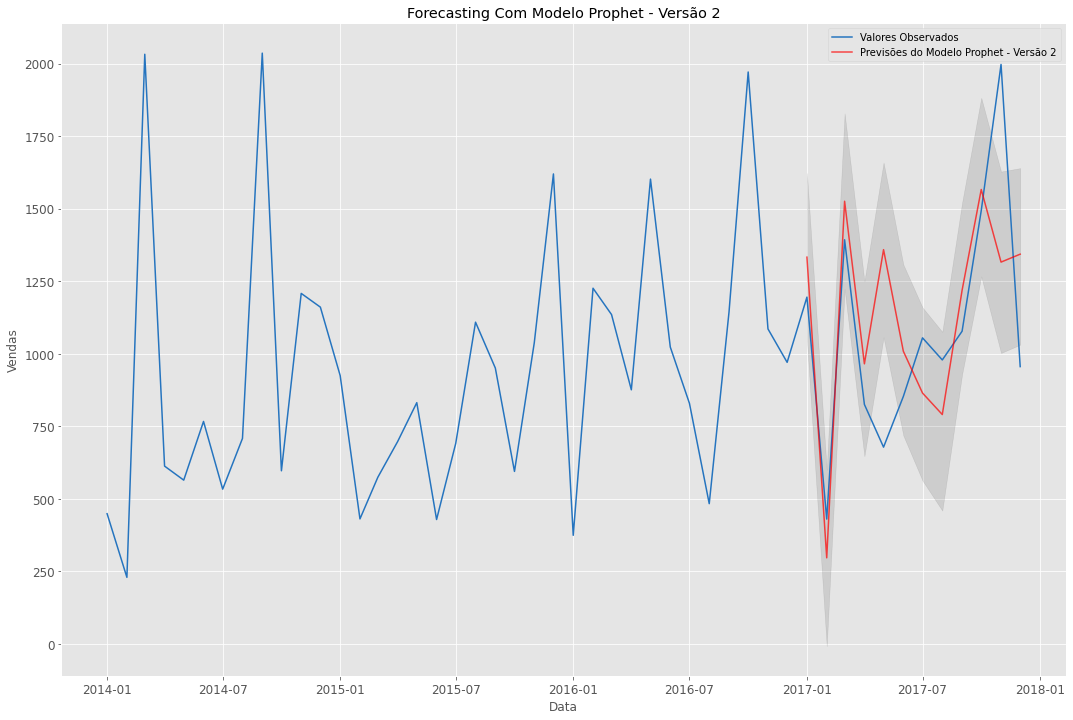

In [0]:
# Plot

# Série original
plt.plot(media_vendas_tecnologia.index, 
         media_vendas_tecnologia.values,
         label = 'Valores Observados',
         color = '#2574BF')

# Previsões
plt.plot(media_vendas_tecnologia[36:48].index, 
         forecast_modelo_prophet[36:48]['yhat'].values,
         label = 'Previsões do Modelo Prophet - Versão 2', 
         alpha = 0.7, 
         color = 'red')

# Limites de Confiança
plt.fill_between(media_vendas_tecnologia[36:48].index,
                 forecast_modelo_prophet[36:48]['yhat_lower'].values,
                 forecast_modelo_prophet[36:48]['yhat_upper'].values, 
                 color = 'k', 
                 alpha = 0.1)

plt.title('Forecasting Com Modelo Prophet - Versão 2')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.legend()
plt.show()

O modelo fez um bom trabalho nas previsões.

Usamos forecast_modelo_prophet[36:48] porque o Prophet gerou 48 meses e nosso dataset de teste tem somente 12 meses.

In [0]:
# Calculando a performance 
prophet_results = performance(testset.values, forecast_modelo_prophet[36:48]['yhat'])
prophet_results

MSE das previsões é 105965.29
RMSE das previsões é 325.52
MAPE das previsões é 26.45


Todas as métricas melhoraram e esse já é o melhor modelo de todos que criamos até aqui. Um recurso tão simples de usar como a inclusão de feriados pode fazer toda a diferença.

Vamos fazer forecast para um horizonte maior.

In [0]:
# Dataset para as previsões
dataset_para_previsoes_60 = modelo_prophet.make_future_dataframe(periods = 55, freq = 'MS')
dataset_para_previsoes_60.count()

ds    91
dtype: int64

In [0]:
dataset_para_previsoes_60.tail()

,ds
86,2021-03-01
87,2021-04-01
88,2021-05-01
89,2021-06-01
90,2021-07-01


In [0]:
# Forecast
forecast_modelo_prophet_60 = modelo_prophet.predict(dataset_para_previsoes_60)

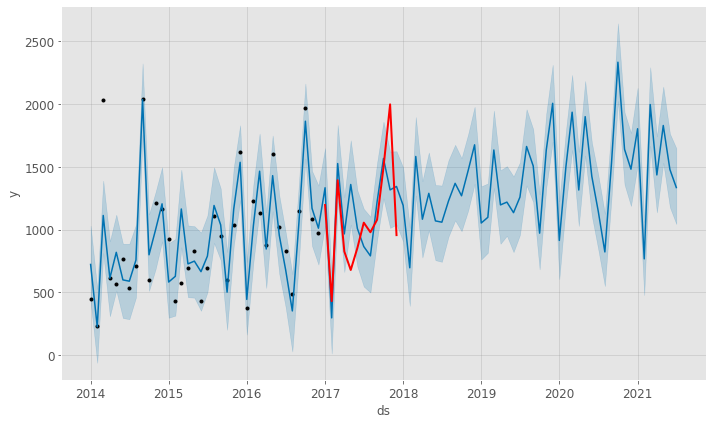

In [0]:
# Vamos criar um Plot e conferir as previsões

# Plot das previsões
fig = modelo_prophet.plot(forecast_modelo_prophet_60)

# Dados de Teste em vermelho
plt.plot(testset, label = 'Teste', color = 'red', linewidth = 2)
plt.show()

As vendas devem manter o mesmo comportamente nos próximos anos.

Infelizmente a métrica AIC não pode ser obtida de forma tão simples no Prophet como fazemos com o Statsmodels. Mas para compensar isso, coloquei em nosso resumo abaixo mais uma métrica dos outros modelos e do Prophet, o MAPE - Mean Absolute Percentage Error. Confira:

Como estamos até agora:
    
- Aula 15 --> Modelo ARMA(1,1) - AIC = 550.3, RMSE = 420.2 e MAPE = 29.58
- Aula 16 --> Modelo ARIMA(6,0,2) - AIC = 559.4, RMSE = 401.5 e MAPE = 26.58
- Aula 17 --> Modelo SARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC = 176.74, RMSE = 425.89 e MAPE = 34.95
- Aula 18 --> Modelo SARIMA(1, 1, 0)x(1, 1, 0, 12) - AIC = 146.77, RMSE = 353.57 e MAPE = 30.55
- Aula 19 --> Modelo SARIMA(1, 1, 0)x(1, 1, 0, 12) com exog  - AIC = 149.66, RMSE = 341.23 e MAPE = 32.54
- Aula 20 --> Modelo Prophet 1 - RMSE = 347.58 e MAPE = 28.53
- Aula 21 --> Modelo Prophet 2 - RMSE = 325.52 e MAPE = 26.45

A diferença com a inclusão dos feriados no modelo Prophet é clara, mas não podemos comemorar. O objetivo foi apenas didático e mostrar o exemplo para você. Com uma série representando as vendas médias o feriado não faz sentido. o Prophet não sabe que a série é uma média e ele considerou os feriados e assim melhorou a performance. Ele fez o trabalho dele!


Mas se tivéssemos uma série convencional (como as médias diárias ou semanais) a melhoria de performance seria ainda maior. Sempre que usar o Prophet, inclua os feriados se a sua série permitir.

Estamos prontos para subir mais um nível! É o que faremos na Aula 22.

# Fim